
=== SOBOL SENSITIVITY RESULTS ===
  beta : S1 = -0.097   ST = 1.048
 gamma : S1 = 0.067   ST = 1.395
    mu : S1 = -0.191   ST = 1.488
   lam : S1 = -0.153   ST = 1.017

=== PRCC RESULTS ===
  beta : PRCC = 0.891
 gamma : PRCC = -0.460
    mu : PRCC = -0.256
   lam : PRCC = 0.339


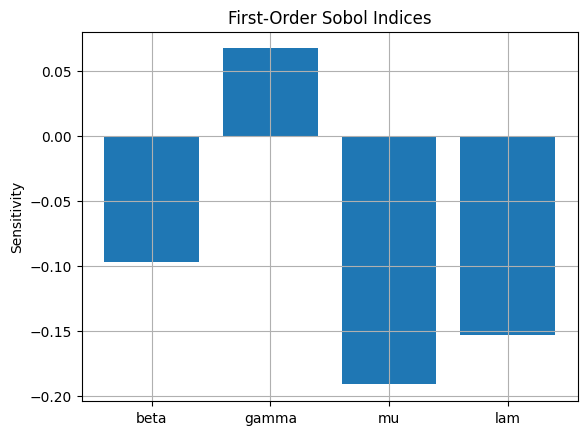

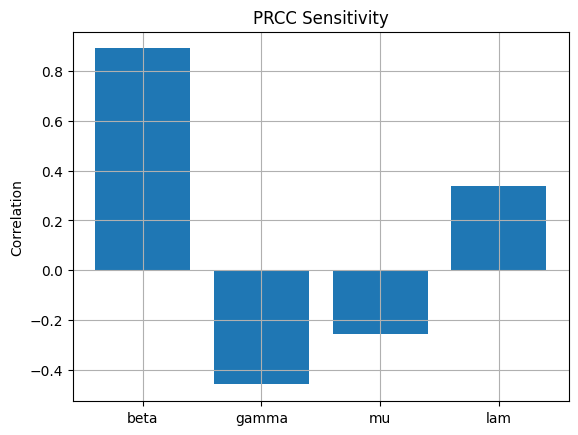

In [5]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from SALib.sample import latin

# ============================================================
# 1. MODEL: Dynamic alpha(t) + addiction SIS tobacco model
# ============================================================

def alpha_t(t, T, lam):
    """Time-dependent pro/anti-tobacco factor a(t)."""
    osc = (1 - np.cos(2 * np.pi * t / T)) / 2
    return 0.7 + 0.3 * np.exp(-lam * t) * osc

def rhs_tobacco(t, y, p):
    """Modified tobacco SIS-type model."""
    S, D = y
    beta, gamma, mu, N, T, lam = (
        p["beta"], p["gamma"], p["mu"], p["N"], p["T"], p["lam"]
    )
    a = alpha_t(t, T, lam)

    dSdt = mu * N - a * beta * S * D / N + gamma * D - mu * S
    dDdt = a * beta * S * D / N - gamma * D - mu * D
    return [dSdt, dDdt]

def simulate(params, t_final=60):
    """Return final smoker fraction D(T)/N."""
    y0 = [0.4, 0.6]  # initial conditions
    sol = solve_ivp(lambda t,y: rhs_tobacco(t,y,params),
                    [0, t_final], y0, max_step=0.1)

    D_end = sol.y[1, -1]
    return D_end / params["N"]

# ============================================================
# 2. GLOBAL SENSITIVITY ANALYSIS — SOBOL (SALib)
# ============================================================

from SALib.sample import saltelli
from SALib.analyze import sobol

# Define the uncertain parameter space
problem = {
    "num_vars": 4,
    "names": ["beta", "gamma", "mu", "lam"],
    "bounds": [
        [0.3, 1.0],      # beta
        [0.05, 0.25],    # gamma
        [0.05, 0.2],     # mu
        [0.005, 0.08]    # lambda (oscillation decay)
    ]
}

# Fixed parameters
N = 1.0
T = 12.0

# Sample the parameter space
#param_values = saltelli.sample(problem, 512)
param_values = latin.sample(problem, 500)

# Run model
Y = []
for p in param_values:
    params = {
        "beta": p[0], "gamma": p[1], "mu": p[2], "lam": p[3],
        "N": N, "T": T
    }
    Y.append(simulate(params))

Y = np.array(Y)

# Compute Sobol indices
Si = sobol.analyze(problem, Y)

print("\n=== SOBOL SENSITIVITY RESULTS ===")
for name, s1, st in zip(problem["names"], Si["S1"], Si["ST"]):
    print(f"{name:>6s} : S1 = {s1:.3f}   ST = {st:.3f}")

# ============================================================
# 3. PRCC (Partial Rank Correlation Coefficient)
# ============================================================

from scipy.stats import rankdata, spearmanr

def compute_prcc(X, Y):
    """Compute PRCC by Spearman partial correlations."""
    R = np.array([rankdata(X[:,i]) for i in range(X.shape[1])]).T
    Ry = rankdata(Y)

    prcc_vals = []
    for j in range(R.shape[1]):
        # All variables except j
        others = np.delete(R, j, axis=1)

        # regress out other parameters
        beta_x = np.linalg.lstsq(others, R[:, j], rcond=None)[0]
        beta_y = np.linalg.lstsq(others, Ry, rcond=None)[0]

        rx = R[:, j] - others @ beta_x
        ry = Ry      - others @ beta_y

        prcc_vals.append(spearmanr(rx, ry)[0])
    return prcc_vals

X = param_values
prcc_vals = compute_prcc(X, Y)

print("\n=== PRCC RESULTS ===")
for name, pr in zip(problem["names"], prcc_vals):
    print(f"{name:>6s} : PRCC = {pr:.3f}")

# ============================================================
# 4. OPTIONAL: Plot results
# ============================================================

plt.figure()
plt.bar(problem["names"], Si["S1"])
plt.title("First-Order Sobol Indices")
plt.ylabel("Sensitivity")
plt.grid(True)
plt.show()

plt.figure()
plt.bar(problem["names"], prcc_vals)
plt.title("PRCC Sensitivity")
plt.ylabel("Correlation")
plt.grid(True)
plt.show()


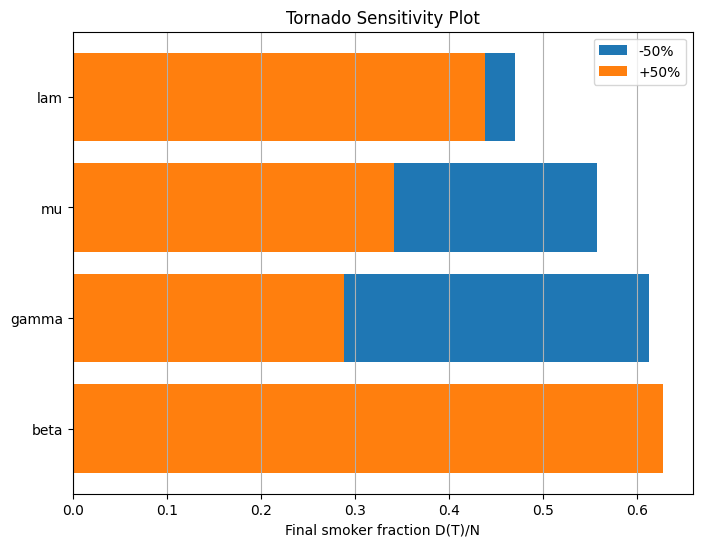

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Tornado plot for the tobacco SIS model with dynamic α(t)
# ------------------------------------------------------------

def tornado_sim(params, t_final=60):
    """Returns final smoker fraction D(T)/N."""
    y0 = [0.4, 0.6]
    sol = solve_ivp(lambda t,y: rhs_tobacco(t,y,params),
                    [0, t_final], y0, max_step=0.1)
    return sol.y[1,-1] / params["N"]

# Base parameter set
base_params = {
    "beta": 0.625,
    "gamma": 0.15,
    "mu": 0.10,
    "lam": 0.03,
    "N": 1.0,
    "T": 12.0
}

param_names = ["beta", "gamma", "mu", "lam"]

low_results = []
high_results = []

for p in param_names:
    p_low  = base_params.copy()
    p_high = base_params.copy()

    p_low[p]  *= 0.5         # -50%
    p_high[p] *= 1.5         # +50%

    low_results.append(tornado_sim(p_low))
    high_results.append(tornado_sim(p_high))

# Plot tornado chart
plt.figure(figsize=(8,6))
y_pos = np.arange(len(param_names))

plt.barh(y_pos, low_results,  color="tab:blue",  label="-50%")
plt.barh(y_pos, high_results, color="tab:orange", label="+50%")

plt.yticks(y_pos, param_names)
plt.xlabel("Final smoker fraction D(T)/N")
plt.title("Tornado Sensitivity Plot")
plt.legend()
plt.grid(True, axis='x')
plt.show()


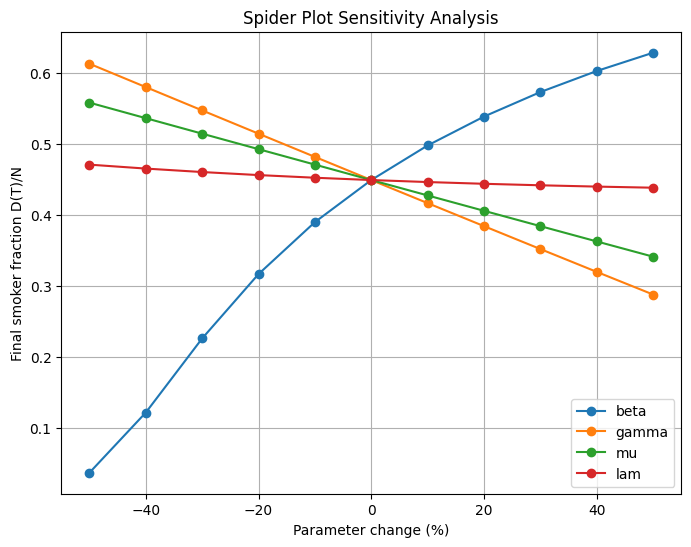

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# ------------------------------------------------------------
# Spider plot for tobacco SIS model
# ------------------------------------------------------------

def run_model_fraction(params):
    """Return final fraction D(T)/N."""
    y0 = [0.4, 0.6]
    sol = solve_ivp(lambda t,y: rhs_tobacco(t,y,params),
                    [0, 60], y0, max_step=0.1)
    return sol.y[1,-1] / params["N"]

base_params = {
    "beta": 0.625,
    "gamma": 0.15,
    "mu": 0.10,
    "lam": 0.03,
    "N": 1.0,
    "T": 12.0
}

param_names = ["beta", "gamma", "mu", "lam"]
num_steps = 11
percent_changes = np.linspace(-0.5, 0.5, num_steps)  # -50% → +50%

plt.figure(figsize=(8,6))

for pname in param_names:
    outputs = []
    for pct in percent_changes:
        params = base_params.copy()
        params[pname] = base_params[pname] * (1 + pct)
        outputs.append(run_model_fraction(params))
    plt.plot(percent_changes * 100, outputs, marker='o', label=pname)

plt.xlabel("Parameter change (%)")
plt.ylabel("Final smoker fraction D(T)/N")
plt.title("Spider Plot Sensitivity Analysis")
plt.legend()
plt.grid(True)
plt.show()


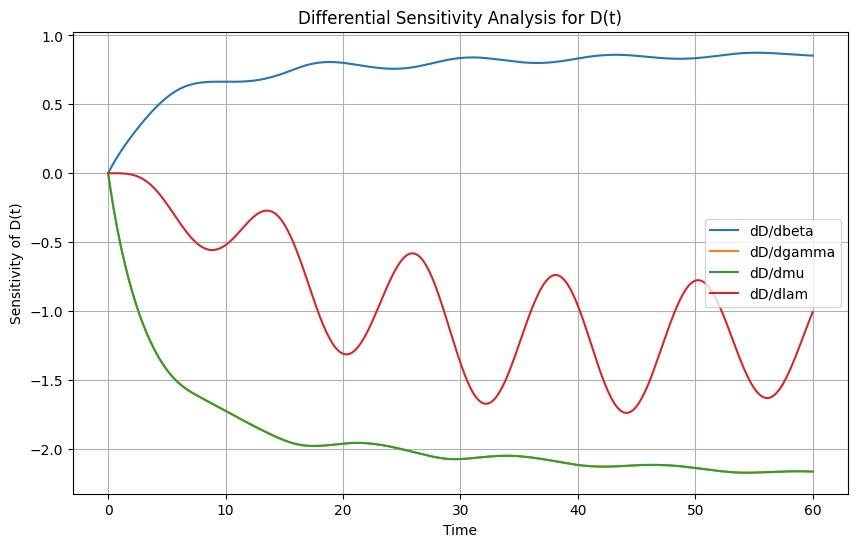

In [4]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Differential Sensitivity for parameter p_j
# ------------------------------------------------------------

def rhs_diff_sensitivity(t, Y, p, p_name):
    """
    Augmented system:
    [S, D, dS/dp, dD/dp]
    """
    S, D, Sp, Dp = Y

    # Base model terms
    beta, gamma, mu, N, T, lam = (
        p["beta"], p["gamma"], p["mu"], p["N"], p["T"], p["lam"]
    )

    a = alpha_t(t, T, lam)

    # f(S,D), g(S,D)
    f = mu*N - a*beta*S*D/N + gamma*D - mu*S
    g = a*beta*S*D/N - gamma*D - mu*D

    # Compute partial derivatives for Jacobian
    # ∂f/∂S, ∂f/∂D, ∂g/∂S, ∂g/∂D
    df_dS = -a*beta*D/N - mu
    df_dD = -a*beta*S/N + gamma
    dg_dS =  a*beta*D/N
    dg_dD =  a*beta*S/N - gamma - mu

    # Partial derivative wrt p_j
    dp = 1e-4  # small perturbation
    p_plus = p.copy()
    p_minus = p.copy()
    p_plus[p_name]  = p[p_name] + dp
    p_minus[p_name] = p[p_name] - dp

    f_p = (rhs_tobacco(t, [S, D], p_plus)[0] -
           rhs_tobacco(t, [S, D], p_minus)[0]) / (2*dp)

    g_p = (rhs_tobacco(t, [S, D], p_plus)[1] -
           rhs_tobacco(t, [S, D], p_minus)[1]) / (2*dp)

    # Augmented ODEs
    dSpdt = f_p + df_dS * Sp + df_dD * Dp
    dDpdt = g_p + dg_dS * Sp + dg_dD * Dp

    return [f, g, dSpdt, dDpdt]

# ------------------------------------------------------------
# Run differential sensitivity for each parameter
# ------------------------------------------------------------

base_params = {
    "beta": 0.625,
    "gamma": 0.15,
    "mu": 0.10,
    "lam": 0.03,
    "N": 1.0,
    "T": 12.0
}

param_names = ["beta", "gamma", "mu", "lam"]

plt.figure(figsize=(10,6))

for pname in param_names:
    sol = solve_ivp(lambda t,y: rhs_diff_sensitivity(t,y,base_params,pname),
                    [0, 60], [0.4, 0.6, 0, 0], t_eval=np.linspace(0,60,500))

    S_p = sol.y[2]
    D_p = sol.y[3]

    plt.plot(sol.t, D_p, label=f"dD/d{pname}")

plt.xlabel("Time")
plt.ylabel("Sensitivity of D(t)")
plt.title("Differential Sensitivity Analysis for D(t)")
plt.grid(True)
plt.legend()
plt.show()
